In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics
from sklearn import ensemble
from scipy import stats as st 
from sklearn import linear_model,datasets
from sklearn.metrics import mean_squared_error

In [212]:
from xgboost import XGBRegressor
from hyperopt import hp,fmin,tpe
from sklearn.model_selection import cross_val_score, KFold


In [211]:
!pip install hyperopt

In [209]:
!pip install xgboost

In [198]:
data=pd.read_csv(r"D:\ml\blackfridayt\train.csv")

In [199]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [118]:
# data cleanning

In [119]:
missing_values = data.isnull().sum().sort_values(ascending = False)

In [120]:
missing_values

Product_Category_3            383247
Product_Category_2            173638
Purchase                           0
Product_Category_1                 0
Marital_Status                     0
Stay_In_Current_City_Years         0
City_Category                      0
Occupation                         0
Age                                0
Gender                             0
Product_ID                         0
User_ID                            0
dtype: int64

In [121]:
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

Product_Category_3    69.672659
Product_Category_2    31.566643
dtype: float64 %


In [122]:
"""believe that the NaN values for Product_Category_2 and Product_Categrory_3 would mean that the concerned person did not buy the products from these categories.

Hence, I believe that it would be safe to replace them with 0."""

'believe that the NaN values for Product_Category_2 and Product_Categrory_3 would mean that the concerned person did not buy the products from these categories.\n\nHence, I believe that it would be safe to replace them with 0.'

In [123]:
data = data.fillna(0)

In [124]:
missing_values = data.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/data.shape[0]
print(f'{missing_values *100} %')

Series([], dtype: float64) %


In [125]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [126]:
# So, the available datatypes are : int64, float64 and objects. We will leave the numeric datatypes alone and focus on object datatypes as the cannot be directly fen into a Machine Learning Model

In [200]:
gender = np.unique(data['Gender'])
gender

array(['F', 'M'], dtype=object)

In [128]:
# So, we do not have any 'Other' gender type. I will create a fuction and map M=1 and F=0. No sexism intended.
def map_gender(gender):
    if gender == 'M':
        return 1
    else:
        return 0
data['Gender'] = data['Gender'].apply(map_gender)


In [195]:
age = np.unique(data['Age'])
age

array(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
      dtype=object)

In [130]:
def map_age(age):
    if age == '0-17':
        return 0
    elif age == '18-25':
        return 1
    elif age == '26-35':
        return 2
    elif age == '36-45':
        return 3
    elif age == '46-50':
        return 4
    elif age == '51-55':
        return 5
    else:
        return 6
data['Age']=data['Age'].apply(map_age)    

In [131]:
city_category = np.unique(data['City_Category'])
city_category

array(['A', 'B', 'C'], dtype=object)

In [132]:
def map_city_categories(city_category):
    if city_category == 'A':
        return 2
    elif city_category == 'B':
        return 1
    else:
        return 0
data['City_Category'] = data['City_Category'].apply(map_city_categories)

In [133]:
city_stay = np.unique(data['Stay_In_Current_City_Years'])
city_stay

array(['0', '1', '2', '3', '4+'], dtype=object)

In [134]:
def map_stay(stay):
        if stay == '4+':
            return 4
        else:
            return int(stay)
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].apply(map_stay)       

In [135]:
cols = ['User_ID','Product_ID']
data.drop(cols, inplace = True, axis =1)

In [136]:
data.describe()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,0.753105,2.496430,8.076707,0.957360,1.858418,0.409653,5.404270,6.735436,3.841941,9263.968713
std,0.431205,1.353632,6.522660,0.760211,1.289443,0.491770,3.936211,6.215492,6.250712,5023.065394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000
25%,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5823.000000
50%,1.000000,2.000000,7.000000,1.000000,2.000000,0.000000,5.000000,5.000000,0.000000,8047.000000
75%,1.000000,3.000000,14.000000,2.000000,3.000000,1.000000,8.000000,14.000000,8.000000,12054.000000
max,1.000000,6.000000,20.000000,2.000000,4.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [137]:
data.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,2,2,0,3,0.0,0.0,8370
1,0,0,10,2,2,0,1,6.0,14.0,15200
2,0,0,10,2,2,0,12,0.0,0.0,1422
3,0,0,10,2,2,0,12,14.0,0.0,1057
4,1,6,16,0,4,0,8,0.0,0.0,7969


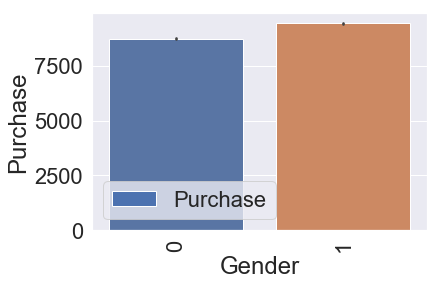

In [138]:
# eda
data[['Gender','Purchase']].groupby('Gender').mean().plot.bar()
sns.barplot('Gender', 'Purchase', data = data)
plt.show()

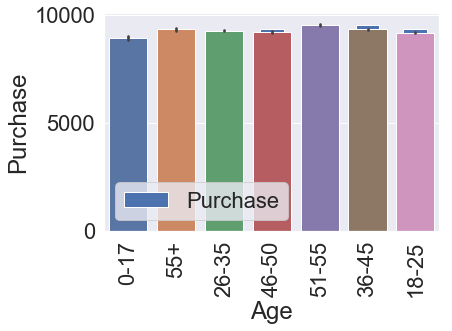

In [201]:
data[['Age','Purchase']].groupby('Age').mean().plot.bar()
sns.barplot('Age', 'Purchase', data = data)
plt.show()

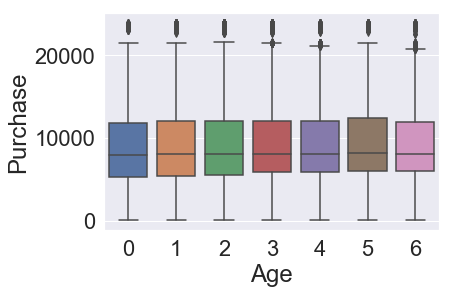

In [140]:
sns.boxplot('Age','Purchase', data = data)
plt.show()


In [141]:
# Not much of a deciation there. We can say that no matter what age group you belong to, you are gonna make full use of your purchasing power on a Black Friday

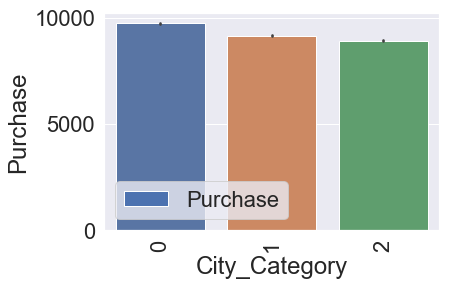

In [142]:
data[['City_Category','Purchase']].groupby('City_Category').mean().plot.bar()
sns.barplot('City_Category', 'Purchase', data = data)
plt.show()

In [143]:
# Okay so, the people belonging to category 0 tend to spend a little more. These may be the more developed cities that we are talking about here.

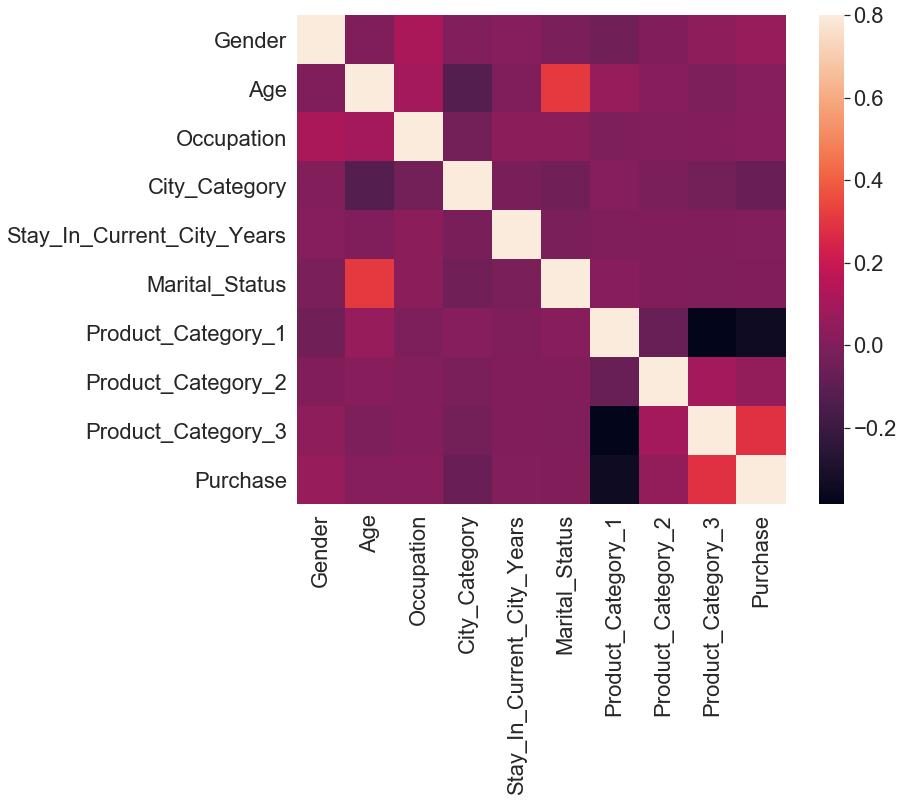

In [144]:
corrmat = data.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [145]:
mean_cat_1 = data['Product_Category_1'].mean()
mean_cat_2 = data['Product_Category_2'].mean()
mean_cat_3= data['Product_Category_3'].mean()
print(f"PC1: {mean_cat_1} \n PC2: {mean_cat_2} \n PC3 : {mean_cat_3}")


PC1: 5.404270017525106 
 PC2: 6.735436346051761 
 PC3 : 3.841941359977312


In [146]:
print(data.skew())

Gender                       -1.173946
Age                           0.808156
Occupation                    0.400140
City_Category                 0.071392
Stay_In_Current_City_Years    0.317236
Marital_Status                0.367437
Product_Category_1            1.025735
Product_Category_2            0.310021
Product_Category_3            1.184926
Purchase                      0.600140
dtype: float64


In [159]:
def skewness_check(data):
    # Find the skewness in the dataset
    skew_value = list(st.skew(data))
    skew_string = []
    # Looping through the skew value to find the Skew category
    for skew in skew_value:
        if skew >= -.5 and skew <= .5:
            skew_string.append("Light Skewed")
        elif skew <= -.5 and skew >= -1 and skew <= .5 and skew >= 1:
            skew_string.append("Moderately Skewed")
        else:
            skew_string.append("Heavily Skewed")
    # Ctreating data frame
    skew_df = pd.DataFrame({'Column': data.columns, 'Skewness': skew_value, 'Skew Category': skew_string})
    return skew_df

# Skewness for Red Wine
skewness_check(data.iloc[:, :-1])

,Column,Skewness,Skew Category
0,Gender,-1.173943,Heavily Skewed
1,Age,0.808153,Heavily Skewed
2,Occupation,0.400139,Light Skewed
3,City_Category,0.071391,Light Skewed
4,Stay_In_Current_City_Years,0.317235,Light Skewed
5,Marital_Status,0.367436,Light Skewed
6,Product_Category_1,1.025732,Heavily Skewed
7,Product_Category_2,0.310020,Light Skewed
8,Product_Category_3,1.184922,Heavily Skewed


In [173]:
# boxcox Transformation
data[["Gender"]] += 0.1
data[["Age"]] += 0.1
data[["Occupation"]] += 0.1
data[["City_Category"]] += 0.1
data[["Stay_In_Current_City_Years"]]+=.1
data[["Marital_Status"]]+=.1
data[["Product_Category_2"]] += 0.1

data[["Product_Category_3"]] += 0.1
def boxcox_trans(data):
    for i in range(data.shape[1]):
        data.iloc[:, i], _ = st.boxcox(data.iloc[:, i])
    return data
# Subset the predcitors
red_trans = data.copy(deep = True)
red_trans.iloc[:, :-1] = boxcox_trans(red_trans.iloc[:, :-1])
skewness_check(red_trans.iloc[:, :-1])

,Column,Skewness,Skew Category
0,Gender,-1.173943,Heavily Skewed
1,Age,0.051755,Light Skewed
2,Occupation,-0.313518,Light Skewed
3,City_Category,-0.359941,Light Skewed
4,Stay_In_Current_City_Years,-0.232544,Light Skewed
5,Marital_Status,0.367436,Light Skewed
6,Product_Category_1,-0.101971,Light Skewed
7,Product_Category_2,-0.349355,Light Skewed
8,Product_Category_3,0.857934,Heavily Skewed


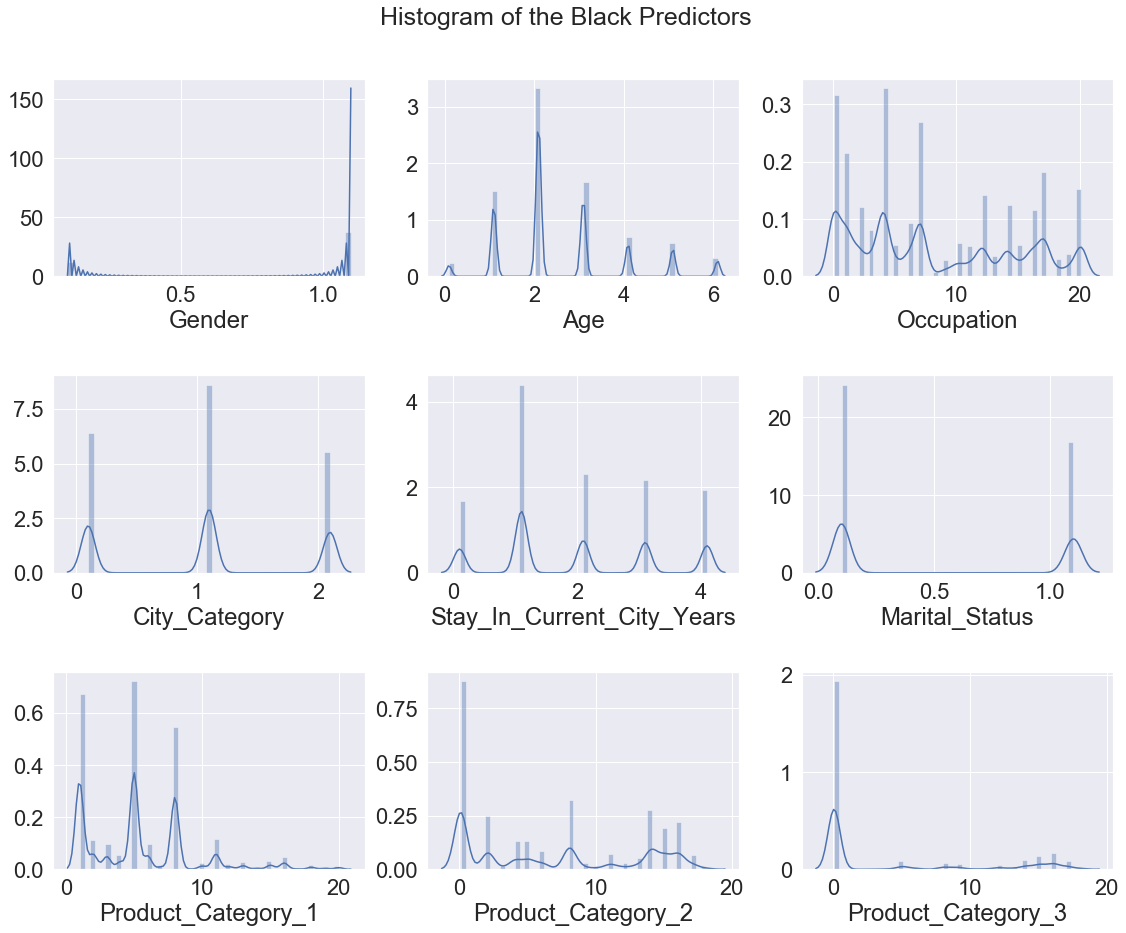

In [174]:
def subplot_hist(data, row = 4, column = 3, title = "Subplots", height = 20, width = 19):
    # Create a figure instance, and the two subplots
    fig = plt.figure(figsize = (width, height))
    fig.suptitle(title, fontsize=25, y = 0.93)
    # Run loop over the all the variables
    for i in range(data.shape[1]):
        # Create the axis line
        ax = fig.add_subplot(row, column, i + 1)
        fig.subplots_adjust(hspace = .5)
        # Create histogram for each variable
        sns.distplot(data.iloc[:, i], ax=ax)

    # Show the plot
    plt.show()
    
subplot_hist(data.iloc[:, :-1], row = 4, column = 3, title = "Histogram of the Black Predictors")

In [175]:
age = np.unique(data['Age'])
age

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1])

In [176]:
city_stay = np.unique(data['Stay_In_Current_City_Years'])
city_stay

array([0.1, 1.1, 2.1, 3.1, 4.1])

In [177]:
city_category = np.unique(data['City_Category'])
city_category

array([0.1, 1.1, 2.1])

In [178]:
gender = np.unique(data['Gender'])
gender

array([0.1, 1.1])

In [179]:
Y = data["Purchase"]

In [180]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

In [181]:
X = data.drop(["Purchase"], axis=1)
X



,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,0.1,0.1,10.1,2.1,2.1,0.1,3,0.1,0.1
1,0.1,0.1,10.1,2.1,2.1,0.1,1,6.1,14.1
2,0.1,0.1,10.1,2.1,2.1,0.1,12,0.1,0.1
3,0.1,0.1,10.1,2.1,2.1,0.1,12,14.1,0.1
4,1.1,6.1,16.1,0.1,4.1,0.1,8,0.1,0.1
5,1.1,2.1,15.1,2.1,3.1,0.1,1,2.1,0.1
6,1.1,4.1,7.1,1.1,2.1,1.1,1,8.1,17.1
7,1.1,4.1,7.1,1.1,2.1,1.1,1,15.1,0.1
8,1.1,4.1,7.1,1.1,2.1,1.1,1,16.1,0.1
9,1.1,2.1,20.1,2.1,1.1,1.1,8,0.1,0.1


In [184]:
X.iloc[:, :-3],

(        Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
 0          0.1  0.1        10.1            2.1                         2.1   
 1          0.1  0.1        10.1            2.1                         2.1   
 2          0.1  0.1        10.1            2.1                         2.1   
 3          0.1  0.1        10.1            2.1                         2.1   
 4          1.1  6.1        16.1            0.1                         4.1   
 5          1.1  2.1        15.1            2.1                         3.1   
 6          1.1  4.1         7.1            1.1                         2.1   
 7          1.1  4.1         7.1            1.1                         2.1   
 8          1.1  4.1         7.1            1.1                         2.1   
 9          1.1  2.1        20.1            2.1                         1.1   
 10         1.1  2.1        20.1            2.1                         1.1   
 11         1.1  2.1        20.1            2.1     

In [206]:
from sklearn.model_selection import train_test_split
x_over_train,x_over_test,y_over_train,y_over_test = train_test_split(X,Y,test_size=0.2,random_state=3)

In [214]:
from sklearn.metrics import mean_squared_error

def rmse(y_,y):
    return mean_squared_error(y_,y)**0.5

def rmse_scorer(model,X,Y):
    y_ = model.predict(X)
    return rmse(y_,Y)
from xgboost import XGBRegressor
from hyperopt import hp,fmin,tpe
from sklearn.model_selection import cross_val_score, KFold

def objective(params):
    params = {
        'n_estimators' : int(params['n_estimators']),
        'max_depth' : int(params['max_depth']),
        'learning_rate' : float(params['learning_rate'])
    }
    
    clf = XGBRegressor(**params,n_jobs=4)
    score = cross_val_score(clf, X, Y, scoring = rmse_scorer, cv=KFold(n_splits=3)).mean()
    print("Parmas {} - {}".format(params,score))
    return score

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 50),
    'max_depth': hp.quniform('max_depth', 4, 20, 4),
    'learning_rate' : hp.uniform('learning_rate',0.05, 0.2) 
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:37:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:42:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/10 [05:01<?, ?it/s, best loss: ?]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:47:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 700, 'max_depth': 16, 'learning_rate': 0.1691869960623422} - 3217.8230355368846
 10%|█         | 1/10 [15:12<2:16:56, 912.94s/it, best loss: 3217.8230355368846]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:52:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 10%|█         | 1/10 [15:13<2:16:56, 912.94s/it, best loss: 3217.8230355368846]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:53:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 10%|█         | 1/10 [15:53<2:16:56, 912.94s/it, best loss: 3217.8230355368846]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:53:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.199537548008498} - 2968.229224695126
 20%|██        | 2/10 [17:14<1:30:04, 675.56s/it, best loss: 2968.229224695126] 

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:54:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 20%|██        | 2/10 [17:14<1:30:04, 675.56s/it, best loss: 2968.229224695126]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:56:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 20%|██        | 2/10 [19:19<1:30:04, 675.56s/it, best loss: 2968.229224695126]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[04:58:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 450, 'max_depth': 12, 'learning_rate': 0.17885897781822552} - 3094.689561613183
 30%|███       | 3/10 [23:28<1:08:15, 585.04s/it, best loss: 2968.229224695126]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 30%|███       | 3/10 [23:28<1:08:15, 585.04s/it, best loss: 2968.229224695126]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:01:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 30%|███       | 3/10 [24:30<1:08:15, 585.04s/it, best loss: 2968.229224695126]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:02:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.06291234490848774} - 2862.874953191034
 40%|████      | 4/10 [26:30<46:25, 464.26s/it, best loss: 2862.874953191034]  

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:03:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 40%|████      | 4/10 [26:31<46:25, 464.26s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:06:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 40%|████      | 4/10 [29:10<46:25, 464.26s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:09:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 950, 'max_depth': 8, 'learning_rate': 0.07591456989892688} - 2867.205721986869
 50%|█████     | 5/10 [34:39<39:18, 471.63s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:12:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 50%|█████     | 5/10 [34:39<39:18, 471.63s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:12:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 50%|█████     | 5/10 [35:20<39:18, 471.63s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:13:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.07715438553711088} - 2882.1832872799473
 60%|██████    | 6/10 [36:42<24:27, 366.93s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:14:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 60%|██████    | 6/10 [36:42<24:27, 366.93s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:17:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 60%|██████    | 6/10 [39:45<24:27, 366.93s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:20:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 450, 'max_depth': 16, 'learning_rate': 0.050937553639694516} - 3119.4966108723656
 70%|███████   | 7/10 [45:53<21:06, 422.15s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:23:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 70%|███████   | 7/10 [45:53<21:06, 422.15s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:26:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 70%|███████   | 7/10 [49:05<21:06, 422.15s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 450, 'max_depth': 16, 'learning_rate': 0.09663120792576436} - 3196.254468607795
 80%|████████  | 8/10 [55:20<15:31, 465.57s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:32:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 80%|████████  | 8/10 [55:20<15:31, 465.57s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:36:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 80%|████████  | 8/10 [58:53<15:31, 465.57s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:39:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.16591108008687167} - 3215.454206513298
 90%|█████████ | 9/10 [1:05:59<08:37, 517.65s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:43:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 90%|█████████ | 9/10 [1:05:59<08:37, 517.65s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:43:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 90%|█████████ | 9/10 [1:06:29<08:37, 517.65s/it, best loss: 2862.874953191034]

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



[05:44:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Parmas {'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.07468119665008963} - 2931.096417862089
100%|██████████| 10/10 [1:07:30<00:00, 389.83s/it, best loss: 2862.874953191034]
